# quant-econ Solutions: LQ Control Problems

Solutions for http://quant-econ.net/py/lqcontrol.html

In [1]:
%matplotlib inline

Common imports for the exercises

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from quantecon import LQ

## Exercise 1

Here’s one solution

We use some fancy plot commands to get a certain style — feel free to use simpler ones


The model is an LQ permanent income / life-cycle model with hump-shaped income

$$    y_t = m_1 t + m_2 t^2 + \sigma w_{t+1} $$

where $\{w_t\}$ is iid $N(0, 1)$ and the coefficients $m_1$ and $m_2$ are chosen so that
$p(t) = m_1  t + m_2  t^2$ has an inverted U shape with

* $p(0) = 0, p(T/2) = \mu$, and 
* $p(T) = 0$.



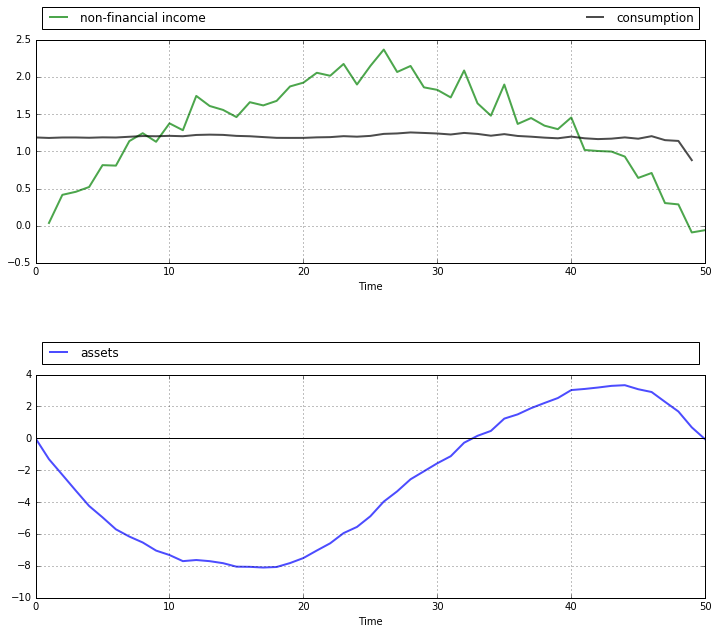

In [3]:
# == Model parameters == #
r       = 0.05
beta    = 1 / (1 + r)
T       = 50
c_bar   = 1.5
sigma   = 0.15
mu      = 2
q       = 1e4
m1      = T * (mu / (T/2)**2)
m2      = - (mu / (T/2)**2)

# == Formulate as an LQ problem == #
Q = 1
R = np.zeros((4, 4)) 
Rf = np.zeros((4, 4))
Rf[0, 0] = q
A = [[1 + r, -c_bar, m1, m2], 
     [0,     1,      0,  0],
     [0,     1,      1,  0],
     [0,     1,      2,  1]]
B = [[-1],
     [0],
     [0],
     [0]]
C = [[sigma],
     [0],
     [0],
     [0]]

# == Compute solutions and simulate == #
lq = LQ(Q, R, A, B, C, beta=beta, T=T, Rf=Rf)
x0 = (0, 1, 0, 0)
xp, up, wp = lq.compute_sequence(x0)

# == Convert results back to assets, consumption and income == #
ap = xp[0, :]               # Assets
c = up.flatten() + c_bar    # Consumption
time = np.arange(1, T+1)
income = wp[0, 1:] + m1 * time + m2 * time**2  # Income


# == Plot results == #
n_rows = 2
fig, axes = plt.subplots(n_rows, 1, figsize=(12, 10))

plt.subplots_adjust(hspace=0.5)
for i in range(n_rows):
    axes[i].grid()
    axes[i].set_xlabel(r'Time')
bbox = (0., 1.02, 1., .102)
legend_args = {'bbox_to_anchor' : bbox, 'loc' : 3, 'mode' : 'expand'}
p_args = {'lw' : 2, 'alpha' : 0.7}

axes[0].plot(range(1, T+1), income, 'g-', label="non-financial income", **p_args)
axes[0].plot(range(T), c, 'k-', label="consumption", **p_args)
axes[0].legend(ncol=2, **legend_args)

axes[1].plot(range(T+1), ap.flatten(), 'b-', label="assets", **p_args)
axes[1].plot(range(T+1), np.zeros(T+1), 'k-')
axes[1].legend(ncol=1, **legend_args)

plt.show()

## Exercise 2

This is  a permanent income / life-cycle model with polynomial growth in income
over working life followed by a fixed retirement income.  The model is solved
by combining two LQ programming problems as described in the lecture.

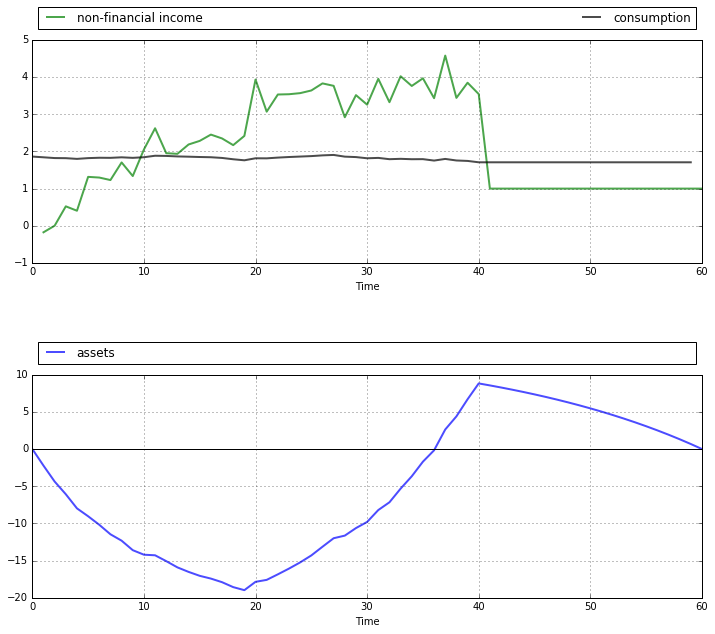

In [4]:
# == Model parameters == #
r       = 0.05
beta    = 1 / (1 + r)
T       = 60
K       = 40
c_bar   = 4
sigma   = 0.35
mu      = 4
q       = 1e4
s       = 1
m1      = 2 * mu / K
m2      = - mu / K**2

# == Formulate LQ problem 1 (retirement) == #
Q = 1
R = np.zeros((4, 4)) 
Rf = np.zeros((4, 4))
Rf[0, 0] = q
A = [[1 + r, s - c_bar, 0, 0], 
     [0,     1,      0,  0],
     [0,     1,      1,  0],
     [0,     1,      2,  1]]
B = [[-1],
     [0],
     [0],
     [0]]
C = [[0],
     [0],
     [0],
     [0]]

# == Initialize LQ instance for retired agent == #
lq_retired = LQ(Q, R, A, B, C, beta=beta, T=T-K, Rf=Rf)
# == Iterate back to start of retirement, record final value function == #
for i in range(T-K):
    lq_retired.update_values()
Rf2 = lq_retired.P

# == Formulate LQ problem 2 (working life) == #
R = np.zeros((4, 4)) 
A = [[1 + r, -c_bar, m1, m2], 
     [0,     1,      0,  0],
     [0,     1,      1,  0],
     [0,     1,      2,  1]]
B = [[-1],
     [0],
     [0],
     [0]]
C = [[sigma],
     [0],
     [0],
     [0]]

# == Set up working life LQ instance with terminal Rf from lq_retired == #
lq_working = LQ(Q, R, A, B, C, beta=beta, T=K, Rf=Rf2)

# == Simulate working state / control paths == #
x0 = (0, 1, 0, 0)
xp_w, up_w, wp_w = lq_working.compute_sequence(x0)
# == Simulate retirement paths (note the initial condition) == #
xp_r, up_r, wp_r = lq_retired.compute_sequence(xp_w[:, K]) 

# == Convert results back to assets, consumption and income == #
xp = np.column_stack((xp_w, xp_r[:, 1:]))
assets = xp[0, :]               # Assets

up = np.column_stack((up_w, up_r))
c = up.flatten() + c_bar    # Consumption

time = np.arange(1, K+1)
income_w = wp_w[0, 1:K+1] + m1 * time + m2 * time**2  # Income
income_r = np.ones(T-K) * s
income = np.concatenate((income_w, income_r))

# == Plot results == #
n_rows = 2
fig, axes = plt.subplots(n_rows, 1, figsize=(12, 10))

plt.subplots_adjust(hspace=0.5)
for i in range(n_rows):
    axes[i].grid()
    axes[i].set_xlabel(r'Time')
bbox = (0., 1.02, 1., .102)
legend_args = {'bbox_to_anchor' : bbox, 'loc' : 3, 'mode' : 'expand'}
p_args = {'lw' : 2, 'alpha' : 0.7}

axes[0].plot(range(1, T+1), income, 'g-', label="non-financial income", **p_args)
axes[0].plot(range(T), c, 'k-', label="consumption", **p_args)
axes[0].legend(ncol=2, **legend_args)

axes[1].plot(range(T+1), assets, 'b-', label="assets", **p_args)
axes[1].plot(range(T+1), np.zeros(T+1), 'k-')
axes[1].legend(ncol=1, **legend_args)

plt.show()

## Exercise 3

The first task is to find the matrices $A, B, C, Q, R$ that define the
LQ problem

Recall that $x_t = (\bar q_t \;\, q_t \;\, 1)'$, while $u_t = q_{t+1} - q_t$

Letting $m_0 := (a_0 - c) / 2a_1$ and $m_1 := 1 / 2 a_1$, we can
write $\bar q_t = m_0 + m_1 d_t$, and then, with some manipulation

$$
    \bar q_{t+1} = m_0 (1 - \rho) + \rho \bar q_t + m_1 \sigma w_{t+1}
$$

By our definition of $u_t$, the dynamics of  $q_t$ are $q_{t+1} = q_t + u_t$

Using these facts you should be able to build the correct $A, B, C$ matrices (and then
check them against those found in the solution code below)

Suitable $R, Q$ matrices can be found by inspecting the objective
function, which we repeat here for convenience:
    
$$
    \min
    \mathbb E \,
    \left\{ 
        \sum_{t=0}^{\infty} \beta^t 
        a_1 ( q_t - \bar q_t)^2 + \gamma u_t^2
    \right\}
$$

Our solution code is


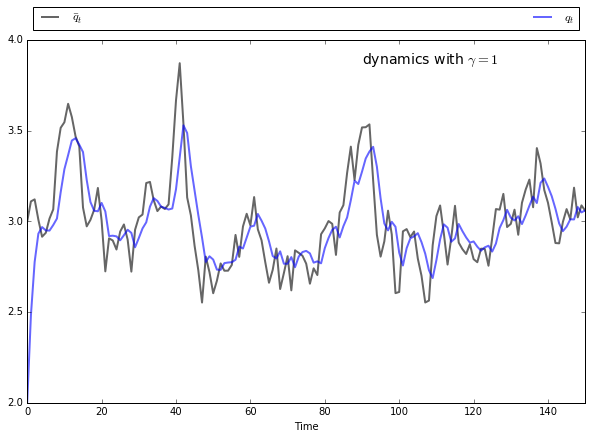

In [5]:
# == Model parameters == #
a0      = 5
a1      = 0.5
sigma   = 0.15
rho     = 0.9
gamma   = 1
beta    = 0.95
c       = 2
T       = 120

# == Useful constants == #
m0 = (a0 - c) / (2 * a1)
m1 = 1 / (2 * a1)

# == Formulate LQ problem == #
Q = gamma
R = [[a1, -a1, 0],
     [-a1, a1, 0],
     [0,   0,  0]]
A = [[rho, 0, m0 * (1 - rho)],
     [0,   1, 0],
     [0,   0, 1]]

B = [[0],
     [1],
     [0]]
C = [[m1 * sigma],
     [0],
     [0]]

lq = LQ(Q, R, A, B, C=C, beta=beta)

# == Simulate state / control paths == #
x0 = (m0, 2, 1)
xp, up, wp = lq.compute_sequence(x0, ts_length=150)
q_bar = xp[0, :] 
q     = xp[1, :]

# == Plot simulation results == #
fig, ax = plt.subplots(figsize=(10, 6.5))
ax.set_xlabel('Time')

# == Some fancy plotting stuff -- simplify if you prefer == #
bbox = (0., 1.01, 1., .101)
legend_args = {'bbox_to_anchor' : bbox, 'loc' : 3, 'mode' : 'expand'}
p_args = {'lw' : 2, 'alpha' : 0.6}

time = range(len(q))
ax.set_xlim(0, max(time))
ax.plot(time, q_bar, 'k-', lw=2, alpha=0.6, label=r'$\bar q_t$')
ax.plot(time, q, 'b-', lw=2, alpha=0.6, label=r'$q_t$')
ax.legend(ncol=2, **legend_args)
s = r'dynamics with $\gamma = {}$'.format(gamma)
ax.text(max(time) * 0.6, 1 * q_bar.max(), s, fontsize=14)
plt.show()